# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

from pyspark.sql import Window
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import re
from pyspark.sql import functions as sF
from pyspark.sql import types as sT

from functools import reduce

In [2]:
# ML imports
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.tuning import CrossValidatorModel as mlm

# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:

data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
# See the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
dfp = df.toPandas()
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [5]:
# Explore the values of some categoric columns
dfp.level.unique(), dfp.method.unique(), dfp.page.unique(), dfp.status.unique(), dfp.gender.unique(), dfp.auth.unique()

(array(['paid', 'free'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
        'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object),
 array([200, 307, 404]),
 array(['M', 'F', None], dtype=object),
 array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object))

In [6]:
dfp[dfp.userId == '']['userId'].count()#, dfp[dfp.sessionId =='']['sessionId'].count()


8346

In [7]:
# Using pandas
# dfp[dfp.sessionId == '']

# Using Spark commands
df.filter(df.sessionId == '').count()

0

In [8]:
# Dropping the missing User's ID rows
df = df.filter(df.userId != '')
# Check! SHOULD be 0
df.filter(df.userId == '').count()

0

In [9]:
# redifine the pandas dataframe
dfp = df.toPandas()

In [10]:
# Explore the values of some categoric columns
dfp.level.unique(), dfp.method.unique(), dfp.page.unique(), dfp.status.unique(), dfp.gender.unique(), dfp.auth.unique()

(array(['paid', 'free'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
        'Add Friend', 'Settings', 'Submit Upgrade', 'About',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation'], dtype=object),
 array([200, 307, 404]),
 array(['M', 'F'], dtype=object),
 array(['Logged In', 'Cancelled'], dtype=object))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
# Let's know the number of users in this dataset and the number of pages and sessions

[f'Unique {col}s: {df.select(col).dropDuplicates().count()}' for col in ('userId', 'page', 'sessionId')]

['Unique userIds: 225', 'Unique pages: 19', 'Unique sessionIds: 2312']

In [12]:

# How many users in the dataset?
df.select('userId').dropDuplicates().count()

225

In [13]:
# Churn is a label for user who cancelled
# Define a flag function
flag_cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# apply to the dataframe
df = df.withColumn("churn", flag_cancelation_event("page"))
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [14]:
dfp = df.toPandas()

# Know number of users who remain and who canceled
# by pandas
dfp.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count()


churn
0    173
1     52
Name: userId, dtype: int64

In [15]:
# by spark
df.dropDuplicates(['userId']).groupby(['churn']).count().show()


+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [16]:
# Exploring user status by gender

df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()


+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



In [17]:
# Exploring user status by paid lever

df.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|   36|
|    1| free|   46|
|    0| free|  149|
|    0| paid|  129|
+-----+-----+-----+



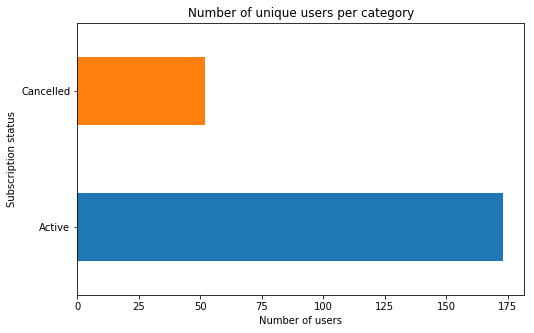

In [18]:

def plot_frequency(subset, group, labels, x_title="Number of users", y_title="Subscription status"):
    ax = dfp.drop_duplicates(subset=subset).groupby(
                                group)['userId'].count().plot(
                                kind='barh', figsize=(8,5), 
                                title='Number of unique users per category');
    ax.set_xlabel(x_title);
    ax.set_yticklabels(labels, rotation=0)
    ax.set_ylabel(y_title);

# Test    
plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

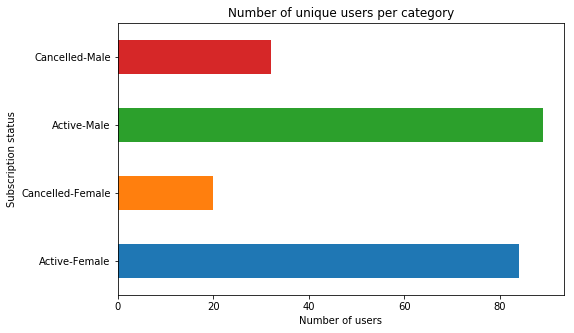

In [19]:
plot_frequency(['userId', 'gender'], 
               ['gender', 'churn'], 
               ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'])

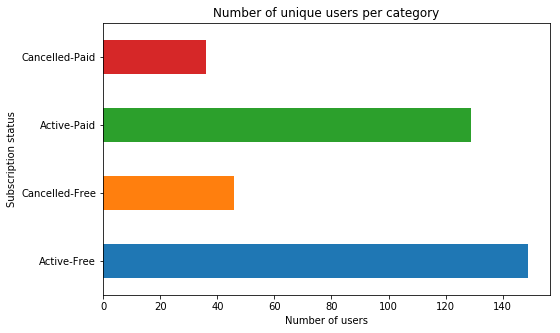

In [20]:
plot_frequency(['userId', 'level'], 
               ['level', 'churn'], 
               ['Active-Free', 'Cancelled-Free', 'Active-Paid', 'Cancelled-Paid'])

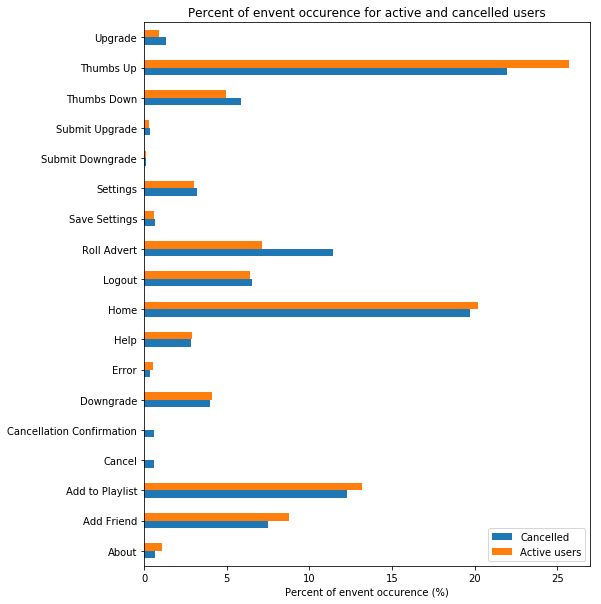

In [21]:

users_1 = dfp[dfp.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
users_1 = users_1 /users_1.sum()*100

users_0 = dfp[dfp.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
users_0 = users_0 /users_0.sum()*100

users_df = pd.DataFrame({'Cancelled': users_1,'Active users':users_0})
ax = users_df.plot(kind='barh', figsize=(8,10));
ax.set_xlabel('Percent of envent occurence (%)')
ax.set_title('Percent of envent occurence for active and cancelled users');

In [22]:
# Definig user functions to get hour, day, month, and weekday of cancellation

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)

# Source https://stackoverflow.com/questions/38928919/how-to-get-the-weekday-from-day-of-month-using-pyspark
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [23]:
# Adding columns to the dataframe
funcs = {'hour':get_hour, 'day':get_day, 'month':get_month, 'week_day':get_weekday}
for label, func in funcs.items():
    df = df.withColumn(label, func(df.ts))
    print(f'Column {label} added successfully.')

Column hour added successfully.
Column day added successfully.
Column month added successfully.
Column week_day added successfully.


In [24]:

# to help in better plotting and visuals
dfp = df.toPandas()
dfp.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,churn,hour,day,month,week_day
264969,Nirvana,Logged In,Ashlynn,F,10,Williams,260.98893,free,"Tallahassee, FL",PUT,...,The Man Who Sold The World,200,1539937856000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",74,0,8,19,10,5
168435,None,Logged In,Riley,F,199,Taylor,NaN,paid,"Boston-Cambridge-Newton, MA-NH",GET,...,None,200,1540070151000,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",92,0,21,20,10,6
96274,None,Logged In,Elizabeth,F,14,Washington,NaN,paid,"Oklahoma City, OK",PUT,...,None,307,1538396265000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",120,0,12,1,10,1
22301,None,Logged In,Samuel,M,37,Wood,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,None,200,1541693389000,"""Mozilla/5.0 (iPad; CPU OS 7_1_1 like Mac OS X...",138,0,16,8,11,4
141383,None,Logged In,Nathan,M,5,Mitchell,NaN,free,"Las Vegas-Henderson-Paradise, NV",PUT,...,None,307,1542725112000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",55,0,14,20,11,2


In [25]:
dfp.userAgent.unique().shape[0]

56

In [26]:
agents = [x.strip() for x  in dfp.userAgent.unique()] 
# see sample
[agents[x] for x in [0, 2, 4, 10]]

['"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"',
 '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
 '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
 '"Mozilla/5.0 (iPad; CPU OS 7_1_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D201 Safari/9537.53"']

In [27]:
# TO get the data between parenthesis
ex = '\(([^\)]*)\)'

# All OSs
sorted(list(set([re.findall(
    ex, x)[0].split(';')[0].capitalize(
) for x  in agents])))

['Compatible',
 'Ipad',
 'Iphone',
 'Macintosh',
 'Windows nt 5.1',
 'Windows nt 6.0',
 'Windows nt 6.1',
 'Windows nt 6.2',
 'Windows nt 6.3',
 'X11']

In [28]:
# Create mappers for the os
mapper_general = {'Compatible': 'Windows',  'Ipad': 'Mac',  'Iphone': 'Mac',  
          'Macintosh': 'Mac',  'Windows nt 5.1': 'Windows',  
          'Windows nt 6.0': 'Windows',  'Windows nt 6.1': 'Windows',  
          'Windows nt 6.2': 'Windows',  'Windows nt 6.3': 'Windows',  
          'X11': 'Linux'}
mapper_specific = {'Compatible': 'Windows 7',  'Ipad': 'iPad',  'Iphone': 'iPhone',  
          'Macintosh': 'MacOS',  'Windows nt 5.1': 'Windows XP',  
          'Windows nt 6.0': 'Windows Vista',  'Windows nt 6.1': 'Windows 7',  
          'Windows nt 6.2': 'Windows 8.0',  'Windows nt 6.3': 'Windows 8.1',  
          'X11': 'Linux'}
print(sorted(list(set([mapper_general[re.findall(ex, x)[0].split(';')[0].capitalize()] for x  in agents]))),
sorted(list(set([mapper_specific[re.findall(ex, x)[0].split(';')[0].capitalize()] for x  in agents]))))

['Linux', 'Mac', 'Windows'] ['Linux', 'MacOS', 'Windows 7', 'Windows 8.0', 'Windows 8.1', 'Windows Vista', 'Windows XP', 'iPad', 'iPhone']


In [29]:
# Define user defined functions
os_general = udf(lambda x: mapper_general[re.findall(ex, x)[0].split(';')[0].capitalize()])
df = df.withColumn("os_general", os_general(df.userAgent))

os_specific = udf(lambda x: mapper_specific[re.findall(ex, x)[0].split(';')[0].capitalize()])
df = df.withColumn("os_specific", os_specific(df.userAgent))

In [30]:

dfp.location.unique().shape[0]

114

In [31]:
states = set([state[1].strip() for state in [x.split(',') for x in dfp.location.unique()]])
len(states)

58

In [32]:
# Define a user defined function
get_state = udf(lambda x: x.split(',')[1].strip())
df = df.withColumn("state", get_state(df.location))

In [33]:
df.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='12', day='8', month='10', week_day='1', os_general='Mac', os_specific='iPhone', state='CT')]

In [34]:
dfp = df.toPandas()
dfp.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,userAgent,userId,churn,hour,day,month,week_day,os_general,os_specific,state
46821,Vangelis,Logged In,Teagan,F,82,Roberts,223.86893,paid,"New Philadelphia-Dover, OH",PUT,...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,28,1,14,30,10,2,Windows,Windows 7,OH
248212,Beck,Logged In,Payton,F,92,Campbell,290.74240,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",39,0,23,15,11,4,Windows,Windows 7,CA
89267,None,Logged In,Lucero,F,4,Reed,NaN,paid,"Louisville/Jefferson County, KY-IN",PUT,...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",140,0,18,22,10,1,Windows,Windows 7,KY-IN
181678,Florence + The Machine,Logged In,Oliver,M,21,Gilbert,219.66322,paid,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",PUT,...,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",81,0,17,30,11,5,Mac,MacOS,PA-NJ-DE-MD
2320,Usher,Logged In,Nicole,F,377,Beck,224.10404,paid,"Vineland-Bridgeton, NJ",PUT,...,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",124,0,5,17,10,3,Mac,MacOS,NJ


In [35]:
draw_time('os_general');


NameError: name 'draw_time' is not defined

In [ ]:
draw_time('os_specific');


In [ ]:
draw_time('state', label_rotation=90);


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [35]:
churn_users = df.select('userId', 'churn').dropDuplicates()

# check
churn_users.show(10)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



In [65]:
churn_users = df.select('userId', 'churn').dropDuplicates()


In [66]:
def create_dummy_df (col, dictionary):
    '''
    Create a dataframe to map a variable
    col: the column name
    dictionary: the mapping of from->to numeric values
    return a dataframe of 2 columns
    '''
    # To map M and F to numeric values, we first should map to string numbers (to avoid spark error)
    col_df = df.select('userId', col).dropDuplicates().replace(dictionary, subset=col)
    # Then convert the result to numeric value
    col_df = col_df.select('userId', col_df[col].cast('int'))
    # Check
    print(col_df.printSchema(), col_df.show(3))
    return col_df


gender_df = create_dummy_df('gender', {'M':'1', 'F':'0'})

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
+------+------+
only showing top 3 rows

None None


In [67]:
os_titles =  df.select('os_specific').distinct().rdd.flatMap(lambda x: x).collect()
os_expr = [sF.when(sF.col('os_specific') == osdt, 1).otherwise(0).alias("OS_" + osdt) for osdt in os_titles]
os_df = df.select('userId', *os_expr)
os_df.show(10)

+------+-------+---------+--------------+--------+----------------+--------------+--------+-------------+------------+
|userId|OS_iPad|OS_iPhone|OS_Windows 8.1|OS_Linux|OS_Windows Vista|OS_Windows 8.0|OS_MacOS|OS_Windows XP|OS_Windows 7|
+------+-------+---------+--------------+--------+----------------+--------------+--------+-------------+------------+
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       

In [68]:
level_df = create_dummy_df('level', {'paid':'1', 'free':'0'})


root
 |-- userId: string (nullable = true)
 |-- level: integer (nullable = true)

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
+------+-----+
only showing top 3 rows

None None


In [69]:
song_length = df.filter(df.page=='NextSong').select('userId', 'sessionId', 'length')
song_length = song_length.withColumn('hours', (song_length.length / 3600))
song_length = song_length.groupBy('userId', 'sessionId').sum('hours')
song_length = song_length.groupBy('userId').agg(
                        sF.avg('sum(hours)').alias('mean_hours'), 
                        sF.stddev('sum(hours)').alias('stdev_hours')).na.fill(0)
song_length.toPandas().head(10)

,userId,mean_hours,stdev_hours
0,100010,2.656385,1.594089
1,200002,4.352263,3.481087
2,125,0.580309,0.000000
3,51,14.535440,11.600663
4,124,10.042779,9.370878
5,7,1.509289,1.737257
6,54,5.645595,6.724164
7,15,9.470389,6.159368
8,155,9.202745,6.528672
9,100014,3.134420,1.754365


In [70]:
# To get the Number of ThumbsUp, ThumbsDown, InviteFriends, downgrades, ...
# I think it is better to get all actions except Chorn actions (Cancel, cancelation confirmation)
# The to normalize them as percent to sum all to 100.

# The distribution of pages per user (FILLING NAN with 0)
user_page_distribution = df.groupby('userId').pivot('page').count().na.fill(0) #.toPandas().head(30)

# Drop Cancel	Cancellation Confirmation columns
user_page_distribution = user_page_distribution.drop(*['Cancel','Cancellation Confirmation'])

# Normalizing each row to sum to 1

# SOURCES
# https://stackoverflow.com/questions/47641076/spark-normalize-each-row-of-a-dataframe
# https://stackoverflow.com/questions/31955309/add-column-sum-as-new-column-in-pyspark-dataframe

# the columns to be summed
pages_cols = user_page_distribution.columns[1:]

# Add a total column
new_df = user_page_distribution.withColumn('total', sum(user_page_distribution[col] for col in pages_cols))

# Apply normalization per column
for col in pages_cols:
    new_df = new_df.withColumn(f'norm_{col}', new_df[col] / new_df['total'] * 100.)
    
# Remove the total column    
new_df = new_df.drop('total')

# Remove the original columns
new_df = new_df.drop(*pages_cols)

# Rename the normalized columns back
oldColumns = new_df.columns
newColumns = ['userId'] + pages_cols
user_page_distribution = reduce(lambda new_df, idx: new_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), new_df)

# Freeup memory
new_df=None

user_page_distribution.toPandas().head(10)

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.000000,0.210970,1.265823,4.430380,0.421941
1,100010,0.262467,1.049869,1.837270,0.000000,0.000000,0.524934,2.887139,1.312336,72.178478,13.648294,0.000000,0.000000,0.000000,0.000000,1.312336,4.461942,0.524934
2,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.888889,11.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,51,0.081235,1.137287,2.112104,0.934200,0.040617,0.487409,3.046304,0.974817,85.743298,0.000000,0.040617,0.487409,0.000000,0.000000,0.852965,4.061738,0.000000
4,124,0.145078,1.533679,2.445596,0.849741,0.124352,0.476684,3.647668,1.222798,84.538860,0.082902,0.124352,0.414508,0.000000,0.000000,0.849741,3.544041,0.000000
5,7,0.000000,0.497512,2.487562,0.000000,0.497512,0.497512,4.975124,1.492537,74.626866,7.960199,0.497512,1.492537,0.000000,0.000000,0.497512,3.482587,0.995025
6,54,0.145560,0.960699,2.096070,1.135371,0.029112,0.494905,3.755459,1.048035,82.707424,1.368268,0.087336,0.494905,0.029112,0.029112,0.844250,4.745269,0.029112
7,15,0.087796,1.360843,2.589991,1.229148,0.087796,0.351185,4.082529,1.185250,84.021071,0.043898,0.087796,0.702371,0.000000,0.000000,0.614574,3.555751,0.000000
8,155,0.199601,1.097804,2.395210,1.197605,0.299401,0.898204,2.994012,1.397206,81.836327,0.798403,0.000000,0.499002,0.000000,0.099800,0.299401,5.788423,0.199601
9,132,0.173611,1.779514,1.649306,0.824653,0.130208,0.694444,3.602431,1.475694,83.680556,0.086806,0.173611,0.737847,0.000000,0.043403,0.737847,4.166667,0.043403


In [71]:
# 2-F Number of songs per session

# number of changing songs
song_user_df = df.filter(df.page == 'NextSong').groupBy(
                        'userId', 'sessionId').count()
song_user_df = song_user_df.groupBy('userId').agg(
                        sF.avg('count').alias('mean_songs'), 
                        sF.stddev('count').alias('stdev_songs'))
song_user_df = song_user_df.na.fill(0)
song_user_df.show(3)

+------+------------------+------------------+
|userId|        mean_songs|       stdev_songs|
+------+------------------+------------------+
|100010|39.285714285714285| 22.96166577663945|
|200002|              64.5|51.309843110264914|
|   125|               8.0|               0.0|
+------+------------------+------------------+
only showing top 3 rows



In [72]:
# Number of artists the user fans
artists_user_fans = df.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "num_aritst")
artists_user_fans.show(3)

+------+----------+
|userId|num_aritst|
+------+----------+
|100010|       253|
|200002|       340|
|   125|         9|
+------+----------+
only showing top 3 rows



In [73]:
# 2-G.1 Session Duration

session_end = df.groupBy('userId', 'sessionId').max('ts').withColumnRenamed(
                                                            'max(ts)', 'end')
session_start = df.groupBy('userId', 'sessionId').min('ts').withColumnRenamed(
                                                            'min(ts)', 'start')
session_df = session_start.join(session_end,['userId', 'sessionId'])
ticks_per_hours = 1000 * 60 * 60
session_df = session_df.select('userId', 'sessionId', ((
    session_df.end-session_df.start)/ticks_per_hours).alias('session_hours'))
session_df.show(3)

+------+---------+------------------+
|userId|sessionId|     session_hours|
+------+---------+------------------+
|   101|      635|55.000277777777775|
|   110|     1776|1.3908333333333334|
|   120|      627|15.855555555555556|
+------+---------+------------------+
only showing top 3 rows



In [74]:
# 2-G.2  Get Average, and Standard deviation of the session duration per user

session_user_df = session_df.groupBy('userId').agg(
                        sF.avg('session_hours').alias('mean_session_h'), 
                        sF.stddev('session_hours').alias('stdev_session_h'))
# Fill NaN with 0
session_user_df = session_user_df.na.fill(0)
session_user_df.show(3)

+------+-------------------+------------------+
|userId|     mean_session_h|   stdev_session_h|
+------+-------------------+------------------+
|100010|  2.574722222222223|1.5888758093219746|
|200002|               4.44| 3.615756029749058|
|   125|0.49277777777777776|               0.0|
+------+-------------------+------------------+
only showing top 3 rows



In [75]:

# 2-H Sessions count per user
num_sessions_user_df = df.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions')
num_sessions_user_df.show(3)

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
+------+------------+
only showing top 3 rows



In [76]:
# 2-I The user's subscription age
def days_since_subscription(df, col_name='days_on'):
    # timestamp of users registration
    reg_ts = df.select('userId', 'registration').dropDuplicates().withColumnRenamed('registration', 'start')
    # reg_ts.show(5)
    # The maximum timestamp found for the user
    end_ts = df.groupBy('userId').max('ts').withColumnRenamed('max(ts)', 'end')
    # end_ts.show(5)
    # The difference
    reg_df = reg_ts.join(end_ts,'userId')
    ticks_per_day = 1000 * 60 * 60 * 24 # as the timestamp is in ticks (0.001 seconds)
    # Merge in one df
    reg_df = reg_df.select('userId', ((reg_df.end-reg_df.start)/ticks_per_day).alias(col_name))
    # reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))
    return reg_df

reg_df = days_since_subscription(df, col_name='days_total_subscription')
reg_df.show(5)

+------+-----------------------+
|userId|days_total_subscription|
+------+-----------------------+
|100010|      55.64365740740741|
|200002|      70.07462962962963|
|   125|      71.31688657407408|
|   124|     131.55591435185184|
|    51|     19.455844907407407|
+------+-----------------------+
only showing top 5 rows



In [77]:
df_paid = df.filter(df.level=='paid')
paid_df = days_since_subscription(df_paid, col_name='days_paid_subscription')
paid_df.show(5)

+------+----------------------+
|userId|days_paid_subscription|
+------+----------------------+
|200002|     70.07462962962963|
|   124|    131.55591435185184|
|    51|    19.455844907407407|
|    15|    56.513576388888886|
|    54|    110.75168981481481|
+------+----------------------+
only showing top 5 rows



In [78]:
df_free = df.filter(df.level=='free')
free_df = days_since_subscription(df_free, col_name='days_free_subscription')
free_df.show(5)

+------+----------------------+
|userId|days_free_subscription|
+------+----------------------+
|100010|     55.64365740740741|
|200002|     41.49415509259259|
|   125|     71.31688657407408|
|     7|     72.77818287037037|
|    54|     96.45179398148149|
+------+----------------------+
only showing top 5 rows



In [79]:

paid_free_df = df.filter(df.page=='NextSong').groupBy('userId').pivot('level').count()
paid_free_df = paid_free_df.na.fill(0)
active_cols = paid_free_df.columns[1:]
paid_free_df = paid_free_df.withColumn('total', 
                                       sum(paid_free_df[col] for col in active_cols))
for col in active_cols:
    paid_free_df = paid_free_df.withColumn(f'{col}_percent', 
                                           paid_free_df[col] / paid_free_df.total * 100)
active_cols.append('total')    
paid_free_df = paid_free_df.drop(*active_cols)
paid_free_df.show(10)

+------+------------------+-----------------+
|userId|      free_percent|     paid_percent|
+------+------------------+-----------------+
|200002| 22.48062015503876|77.51937984496125|
|100010|             100.0|              0.0|
|   125|             100.0|              0.0|
|     7|             100.0|              0.0|
|   124|               0.0|            100.0|
|    51|               0.0|            100.0|
|    54|15.452305526223162|84.54769447377683|
|    15|               0.0|            100.0|
|   155|12.317073170731707| 87.6829268292683|
|   132|1.4522821576763485|98.54771784232366|
+------+------------------+-----------------+
only showing top 10 rows



In [80]:
paid_free_df = paid_free_df.drop('free_percent')
paid_free_df.show(3)

+------+-----------------+
|userId|     paid_percent|
+------+-----------------+
|200002|77.51937984496125|
|100010|              0.0|
|   125|              0.0|
+------+-----------------+
only showing top 3 rows



In [81]:
# the features to collect
user_features = [gender_df, os_df, paid_free_df, song_length, 
                   user_page_distribution, song_user_df, artists_user_fans, 
                   session_user_df, num_sessions_user_df, reg_df]
user_features_names = ['gender_df', 'os_df', 'paid_free_df', 'song_length', 
                   'user_page_distribution', 'song_user_df', 'artists_user_fans', 
                   'session_user_df', 'num_sessions_user_df', 'reg_df']

In [82]:

# Initialize the final_df
final_df = chorn_users

def join_features(base, new):
    df_to_join = new#.withColumnRenamed('userId', 't_userId')
    base = base.join(df_to_join, 'userId', how='inner')#.drop('t_userId')#.show(10)
    return base.dropDuplicates()

for i, feature in enumerate(user_features):
    print(f'Preparing features of the {user_features_names[i]} dataframe', end='; ')
    final_df = join_features(final_df, feature)
    print (f"the new frame's dimensions is: {final_df.count()} * {len(final_df.columns)}")
final_df = final_df.orderBy('userId', ascending=True)
print('*** ALL DONE ***')

NameError: name 'chorn_users' is not defined

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [83]:
final_df = spark.read.csv('saved_user_dataset.CSV', header = True)
pfinal_df = final_df.toPandas()


AnalysisException: 'Path does not exist: file:/home/workspace/saved_user_dataset.CSV;'

In [ ]:

# Initialize the final_df
final_df = chorn_users

def join_features(base, new):
    df_to_join = new#.withColumnRenamed('userId', 't_userId')
    base = base.join(df_to_join, 'userId', how='inner')#.drop('t_userId')#.show(10)
    return base.dropDuplicates()

for i, feature in enumerate(user_features):
    print(f'Preparing features of the {user_features_names[i]} dataframe', end='; ')
    final_df = join_features(final_df, feature)
    print (f"the new frame's dimensions is: {final_df.count()} * {len(final_df.columns)}")
final_df = final_df.orderBy('userId', ascending=True)
print('*** ALL DONE ***')

In [ ]:
final_df.write.save('saved_user_dataset.CSV', format='csv', header=True)

final_dfp = final_df.toPandas()
final_dfp.to_csv('saved_user_dataset_pd.CSV', index=False)

final_df = spark.read.csv('saved_user_dataset.CSV', header = True)
pfinal_df = final_df.toPandas()
pfinal_df.head()

In [ ]:
# Change the column names to strings without spaces
for col in final_df.columns:
    final_df = final_df.withColumnRenamed(col, col.replace(' ', '_').replace('.', ''))
print(final_df.columns)

In [ ]:
# Convert all to numbers as the schema shows strings
# the first column (userId) would be integer
final_df = final_df.withColumn('userId', final_df.userId.cast(sT.IntegerType()))
# All columns from Churn to OS_* should be integer types
for col in final_df.columns[1:12]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.IntegerType()))
# All other columns should be float
for col in final_df.columns[12:]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.FloatType()))

final_df.printSchema()

In [ ]:

# Remove  nulls from anywhere replacing them by zeros
final_df = final_df.na.fill(0)

In [ ]:
# Get features labels for plotting purposes
features_labels = final_df.columns[2:]

In [ ]:
# The input features are all but the userId and the Churn
# The output is Churn only

# Define the vector assembler for all input columns
features_vector = VectorAssembler(inputCols=final_df.columns[2:], outputCol='features')

# Apply the vectorization on the dataset
input_data = features_vector.transform(final_df)
# input_data.show(1)

In [ ]:
features_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scaler_fit = features_scaler.fit(input_data)
scaled_inputs = features_scaler_fit.transform(input_data)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.